# rewardGym Tutorial

This tutorial is supposed to be both a tutorial about the usage of the package,
and a walkthrough of the functionality.

In this tutorial, we will implement a classic multi-arm (two) bandit task, and
provide simple rendering in pygame, so that humans can play the game as well.

## The environment

rewardGym uses a sub-class of the gymnasium gym.Env.

The basic environment, requires a graph as input, and a dictionary, that relates
identifies the reward nodes (i.e. the endpoints of the graph).

In this implementation the graph has three nodes.

The first node is the starting position, where the agent has to decide which
of the two lotteries it wants to select.

The second and third node are both endpoints of the graph, which are associated
with a reward.

In [1]:
# noqa: E402
# We first import the BaseEnv
from rewardgym.environments import BaseEnv
from rewardgym.reward_classes import BaseReward

Registered task: mid
Registered task: robotfactory
Registered task: risk-sensitive
Registered task: gonogo
Registered task: posner
Registered task: hcp
Registered task: two-step


The graph is created as a dictionary, where each node is a key and the possible
positions in the graph the agent could move to.
End nodes (empty lists) are automatically reward locations.

In [2]:
env_graph = {0: [1, 2], 1: [], 2: []}
# Side note, this is the same structure as used in the HCP task.

We further need to define a reward the we will use. In this package the reward
is defined by a callable class.
The basic class used here, allows for probabilistic or static rewards.

In the case of the two-armed bandit task here, we will use two simple probabilistic
reward outcomes.

In [3]:
# The reward is chosen using numpy.random.choice, so we define the range of rewards
# and the associated probability.
reward1 = BaseReward(reward=[0, 1], p=[0.2, 0.8], random_state=2222)
reward2 = BaseReward(reward=[0, 1], p=[0.5, 0.5], random_state=3333)

# This creates the reward dictionary necessary for the environment.
reward_locs = {1: reward1, 2: reward2}

# The reward class is then callable using:
print("Reward 1: ", reward1())

Reward 1:  1


With these two components we can create an environment:

In [4]:
env = BaseEnv(environment_graph=env_graph, reward_locations=reward_locs)

There is some plotting functionality, which allows the plotting of the structure.

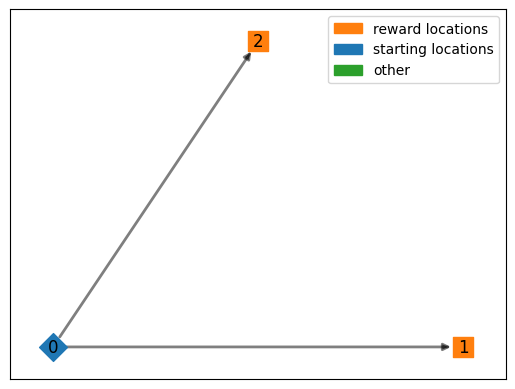

In [5]:
from rewardgym.environments.visualizations import plot_env_graph

plot_env_graph(env)

We see here, that the environment has three states and two possible actions.

## Putting the environment into action

The API follows the gym/gymnasium structure. An example loop over the environment
might look like this:



In [6]:
import matplotlib.pyplot as plt
import numpy as np

n_episodes = 100
rewards_and_actions = np.zeros((2, n_episodes))  # book keeping of actions and rewards

for t in range(n_episodes):
    # currently we need to define the agent location at each reset.
    obs, info = env.reset(agent_location=0)

    done = False

    while not done:
        # Sample from the action space, the action space is automatically created
        # it has the size of the largest number of possible moves.
        action = env.action_space.sample()

        next_obs, reward, terminated, truncated, info = env.step(action)

        # Don't forget to terminate, whence the episode / trial is over
        done = terminated or truncated
    rewards_and_actions[:, t] = [reward, action]

As a sanity check, we can calculate the total reward of the agent after each
action.

[[<matplotlib.axis.XTick at 0x7f2e68de9f60>,
 [Text(0, 0, 'Action 0'), Text(1, 0, 'Action 1')],
 Text(0.5, 1.0, 'Outcome after each action'),
 Text(0, 0.5, 'total reward')]

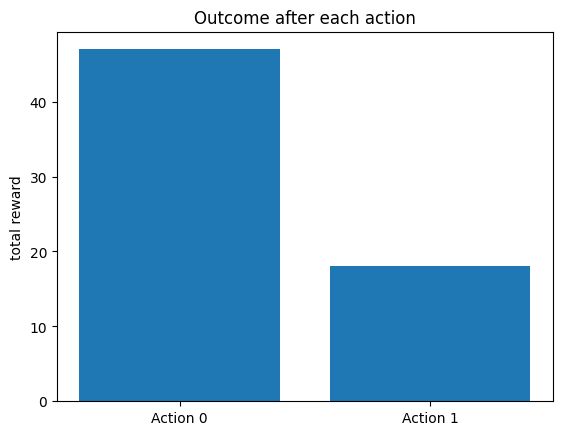

In [7]:
total_rew1 = np.sum(rewards_and_actions[0, rewards_and_actions[1, :] == 0])
total_rew2 = np.sum(rewards_and_actions[0, rewards_and_actions[1, :] == 1])

fig, ax = plt.subplots()
ax.bar(np.arange(2), [total_rew1, total_rew2])
ax.set(
    xticks=[0, 1],
    xticklabels=["Action 0", "Action 1"],
    title="Outcome after each action",
    ylabel="total reward",
)

## Providing Rendering

If you now want a human to play the game you will need to provide some information
to allow rendering with ``pygame``.

One logic that is used here, is that the environments themselves are Markovian,
that is each state has all the information necessary to generate an action.

The issue, however, is that most tasks are not necessarily Markovian, as there
are fixation periods and other step in between states, actions, and outcomes.

Here, we go a middle ground. It is possible to define intermediate steps for
the rendering process, but the returned observations of the environment all
require an action.

I hope this becomes at bit clearer in the next steps.

We will use only letters for rendering, to make it more simple, and so that there
are no further requirements.

We create each step separately, before merging them into the main display dictionary.


In [8]:
import pygame

from rewardgym.pygame_render.stimuli import BaseAction, BaseDisplay, BaseText

# State / Step1:
# We first want to blank the screen, this can be done with the BaseDisplay class
# The class can also be used to show images, but if it's not defined,
# it will only flip the screen. The time is in ms.

flip_screen = BaseDisplay(image=None, duration=1, name="blank")

# Unfortunately, we need to know the screen size in the beginning, if we want
# to position text in the center.
window_size = 500  # Let's use 500 by 500 px.
center_position = (window_size // 2, window_size // 2)
# We then define a text, that presents a cross in the center.
fixation_cross = BaseText("+", duration=200, textposition=center_position)
# Next we want to present the selection, we use a very short duration,
# as we present an action afterwards.
selection = BaseText("A or B", duration=1, textposition=center_position)
# Base action has an infinite length, it waits until an action is ushered.
action = BaseAction(action_map={pygame.K_LEFT: 0, pygame.K_RIGHT: 1})

# To store the first step and use it in the environment later we create a
# dictionary. The nexted dict, with "human" as key, indicates that it should be
# used for rendering.

info_dict = {0: {"human": [flip_screen, fixation_cross, selection, action]}}

In [9]:
from rewardgym.pygame_render.task_stims import FormatTextReward

# Step 2 and step three are basically the same, so we can define them once
# and reuse the code.
# In this simple implementation, after a selection, the participant will see
# their reward immediately.

reward_disp = FormatTextReward(
    "You gain: {0}", duration=1000, textposition=center_position, target="reward"
)

earnings_text = FormatTextReward(
    "You have gained: {0}",
    duration=500,
    textposition=center_position,
    target="total_reward",
)
# The format texts, use inputs during the loop to update the value according
# to some input.
# NOTE: These functions are currently a bit messy and will be cleaned up
# in future versions of the package.
# NOTE: Because the pygame implementation, uses similar displays through out,
# there is a helper function ``rewardgym.pygame_render.task_stims.feedback_block``,
# that creates the two feedbacks using some default values.

info_dict[1] = {
    "human": [flip_screen, reward_disp, earnings_text]  # Just for good measure
}

info_dict[2] = {
    "human": [flip_screen, reward_disp, earnings_text]  # Just for good measure
}

We can now move this all into a ``RenderEnv`` which allows rendering of the
environment.

In [10]:
from rewardgym.environments import RenderEnv

env = RenderEnv(
    environment_graph=env_graph,
    reward_locations=reward_locs,
    render_mode="pygame",
    info_dict=info_dict,
)

env.setup_render(window_size=window_size)

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


And again we can use a simple loop to go through the environment.
This time human actions will be stored and applied to the decisions, and a
new window is opened for rendering.

**NOTE** This might not work well in some environments.

In [11]:
n_episodes = 0  # Change to a higher number, disabled here for rendering.

for episode in range(n_episodes):
    obs, info = env.reset(agent_location=0)
    done = False
    # play one episode
    while not done:
        action = env.human_action
        next_obs, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        obs = next_obs

env.close()